In [1]:
!nvidia-smi

Tue Apr 23 04:33:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

⚠️ YOLOv8 is still under heavy development. Breaking changes are being introduced almost weekly. We strive to make our YOLOv8 notebooks work with the latest version of the library. Last tests took place on **03.01.2024** with version **YOLOv8.0.196**.

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [3]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/78.2 GB disk)


In [4]:
# Git clone method (for development)

# %cd {HOME}
# !git clone github.com/ultralytics/ultralytics
# %cd {HOME}/ultralytics
# !pip install -e .

# from IPython import display
# display.clear_output()

# import ultralytics
# ultralytics.checks()

In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

In [6]:
%cd {HOME}
!yolo task=segment mode=predict model=yolov8s-seg.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=true

/content
100% 22.8M/22.8M [00:00<00:00, 47.9MB/s]
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11810560 parameters, 0 gradients, 42.6 GFLOPs

100% 104k/104k [00:00<00:00, 113MB/s]
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 backpack, 1 handbag, 108.8ms
Speed: 12.3ms preprocess, 108.8ms inference, 995.9ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


/content


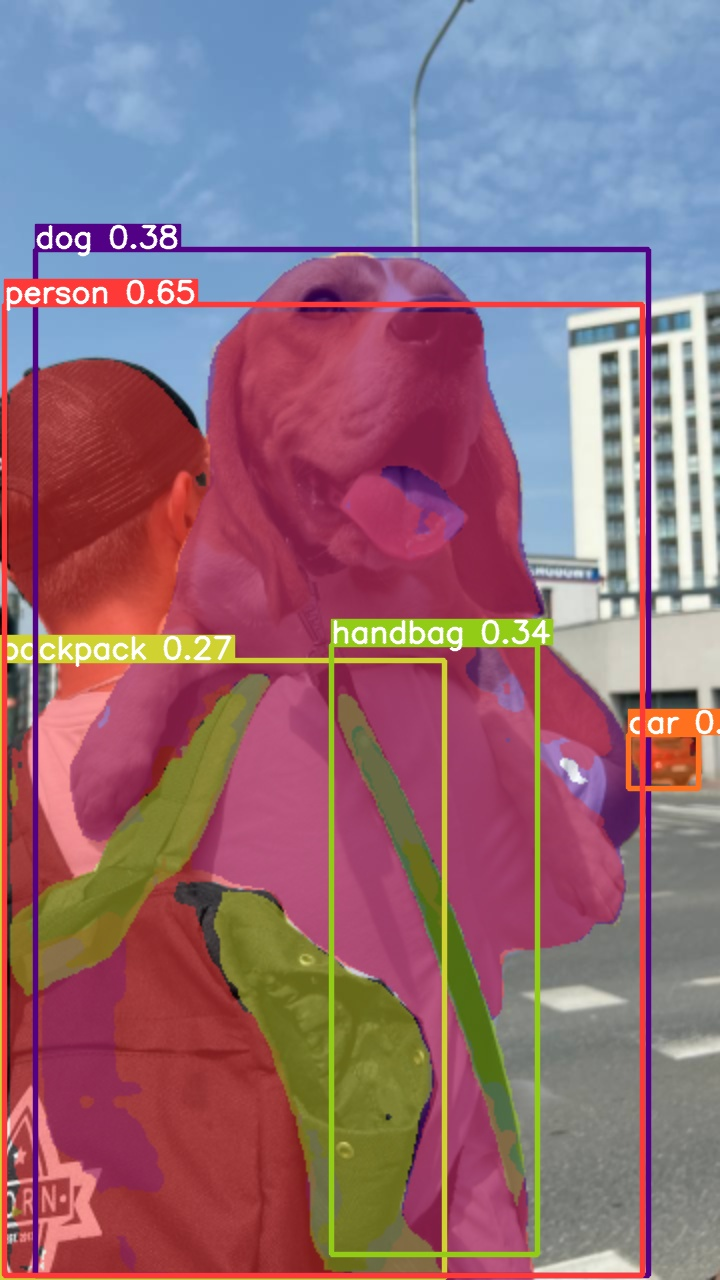

In [7]:
%cd {HOME}
Image(filename='runs/segment/predict/dog.jpeg', height=600)

### 🐍 Python SDK

The simplest way of simply using YOLOv8 directly in a Python environment.

In [8]:
model = YOLO(f'{HOME}/yolov8s-seg.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)


Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 backpack, 1 handbag, 262.1ms
Speed: 8.2ms preprocess, 262.1ms inference, 877.2ms postprocess per image at shape (1, 3, 640, 384)


In [9]:
results[0].boxes.xyxy

tensor([[4.4446e+00, 3.0434e+02, 6.4261e+02, 1.2755e+03],
        [6.2834e+02, 7.3451e+02, 6.9819e+02, 7.8832e+02],
        [3.5369e+01, 2.4992e+02, 6.4884e+02, 1.2759e+03],
        [3.3150e+02, 6.4431e+02, 5.3794e+02, 1.2545e+03],
        [8.8925e-01, 6.6045e+02, 4.4417e+02, 1.2785e+03]], device='cuda:0')

In [10]:
results[0].boxes.conf

tensor([0.6489, 0.5239, 0.3784, 0.3442, 0.2668], device='cuda:0')

In [11]:
results[0].boxes.cls

tensor([ 0.,  2., 16., 26., 24.], device='cuda:0')

## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.


### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.



### Step 3: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.



### Step 4: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v5 PyTorch` dataset format.




In [6]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vJMcGR311YxwtsJyqPfR")
project = rf.workspace("minor-project-2-qrehi").project("coral_segmentation-wdpo7")
version = project.version(9)
dataset = version.download("yolov8")


/content/datasets
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully unin

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Coral_Segmentation-9 in yolov8:: 100%|██████████| 3120/3120 [00:00<00:00, 5643.87it/s]


## Custom Training

In [7]:
%cd {HOME}

!yolo task=segment mode=train model=yolov8s-seg.pt data={dataset.location}/data.yaml epochs=100 imgsz=640

/content
New https://pypi.org/project/ultralytics/8.2.2 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=/content/datasets/Coral_Segmentation-9/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None,

In [8]:
!ls {HOME}/runs/segment/train/

args.yaml  weights


/content


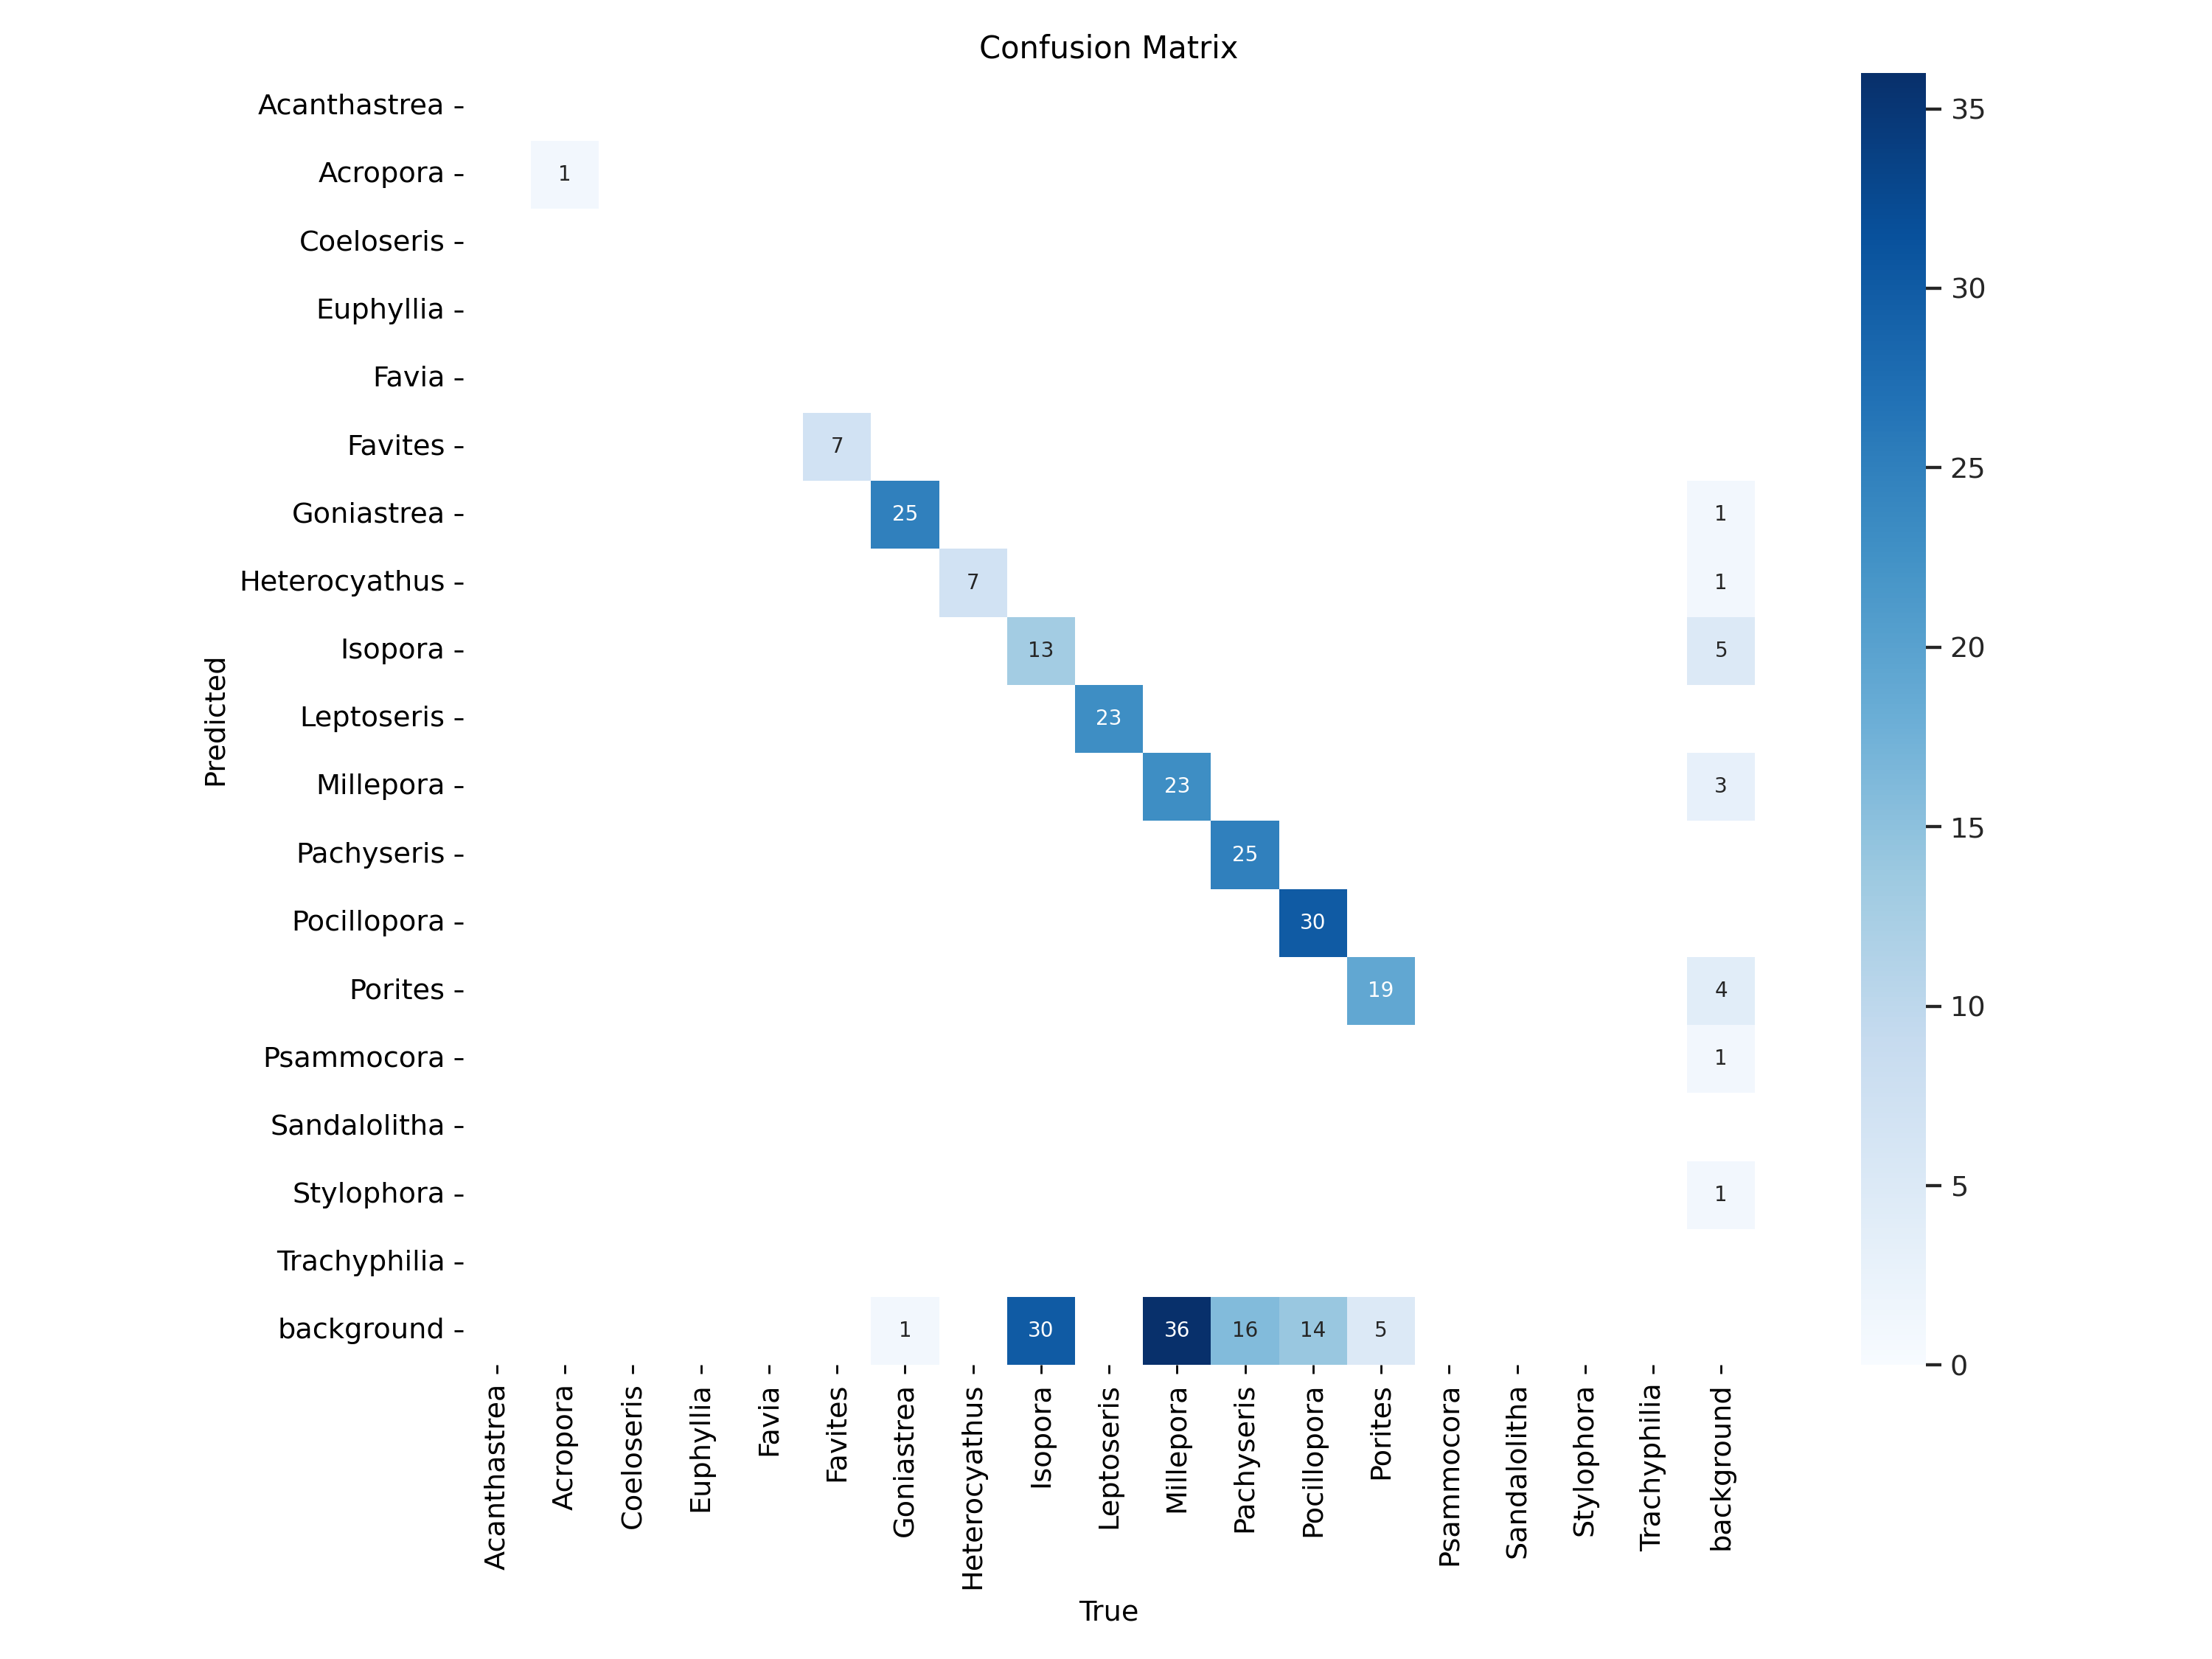

In [12]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train2/confusion_matrix.png', width=600)

/content


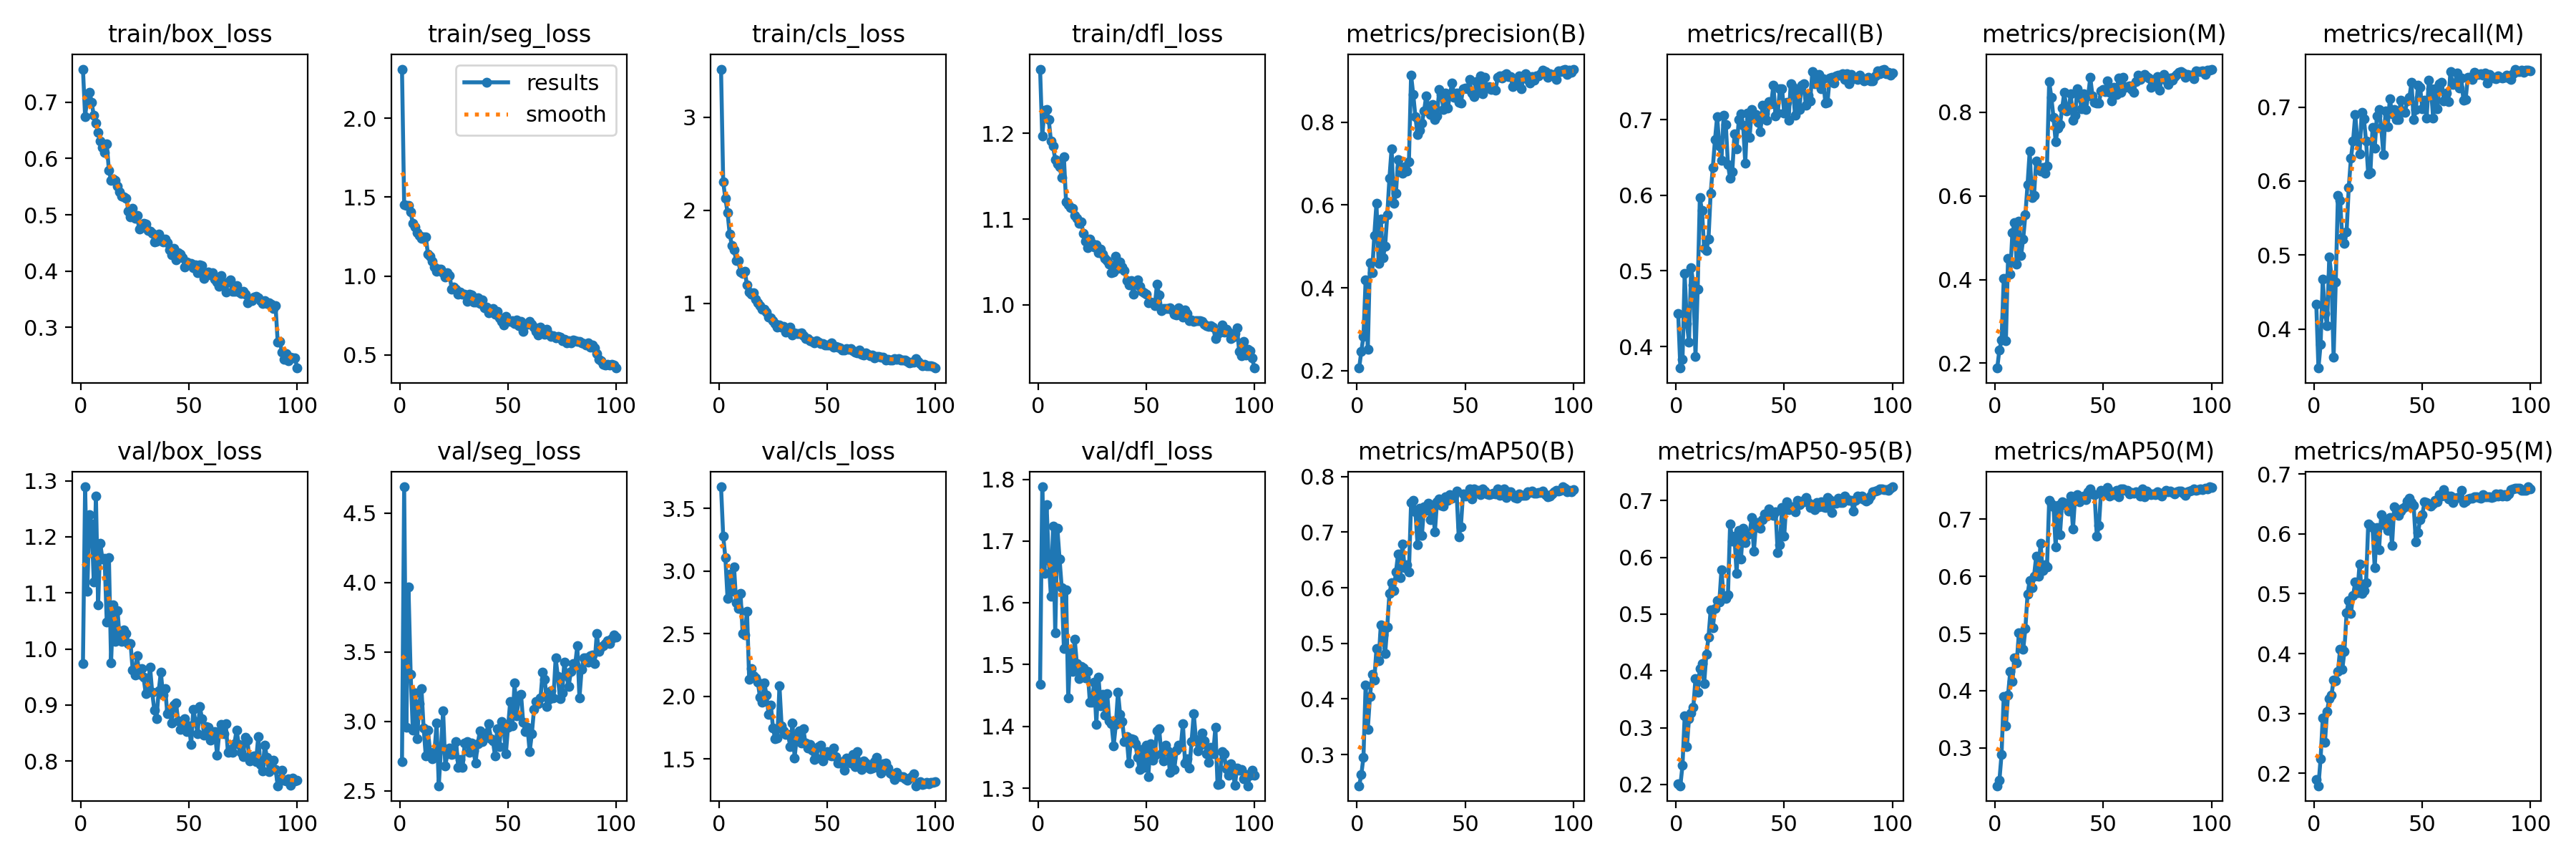

In [13]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train2/results.png', width=600)

/content


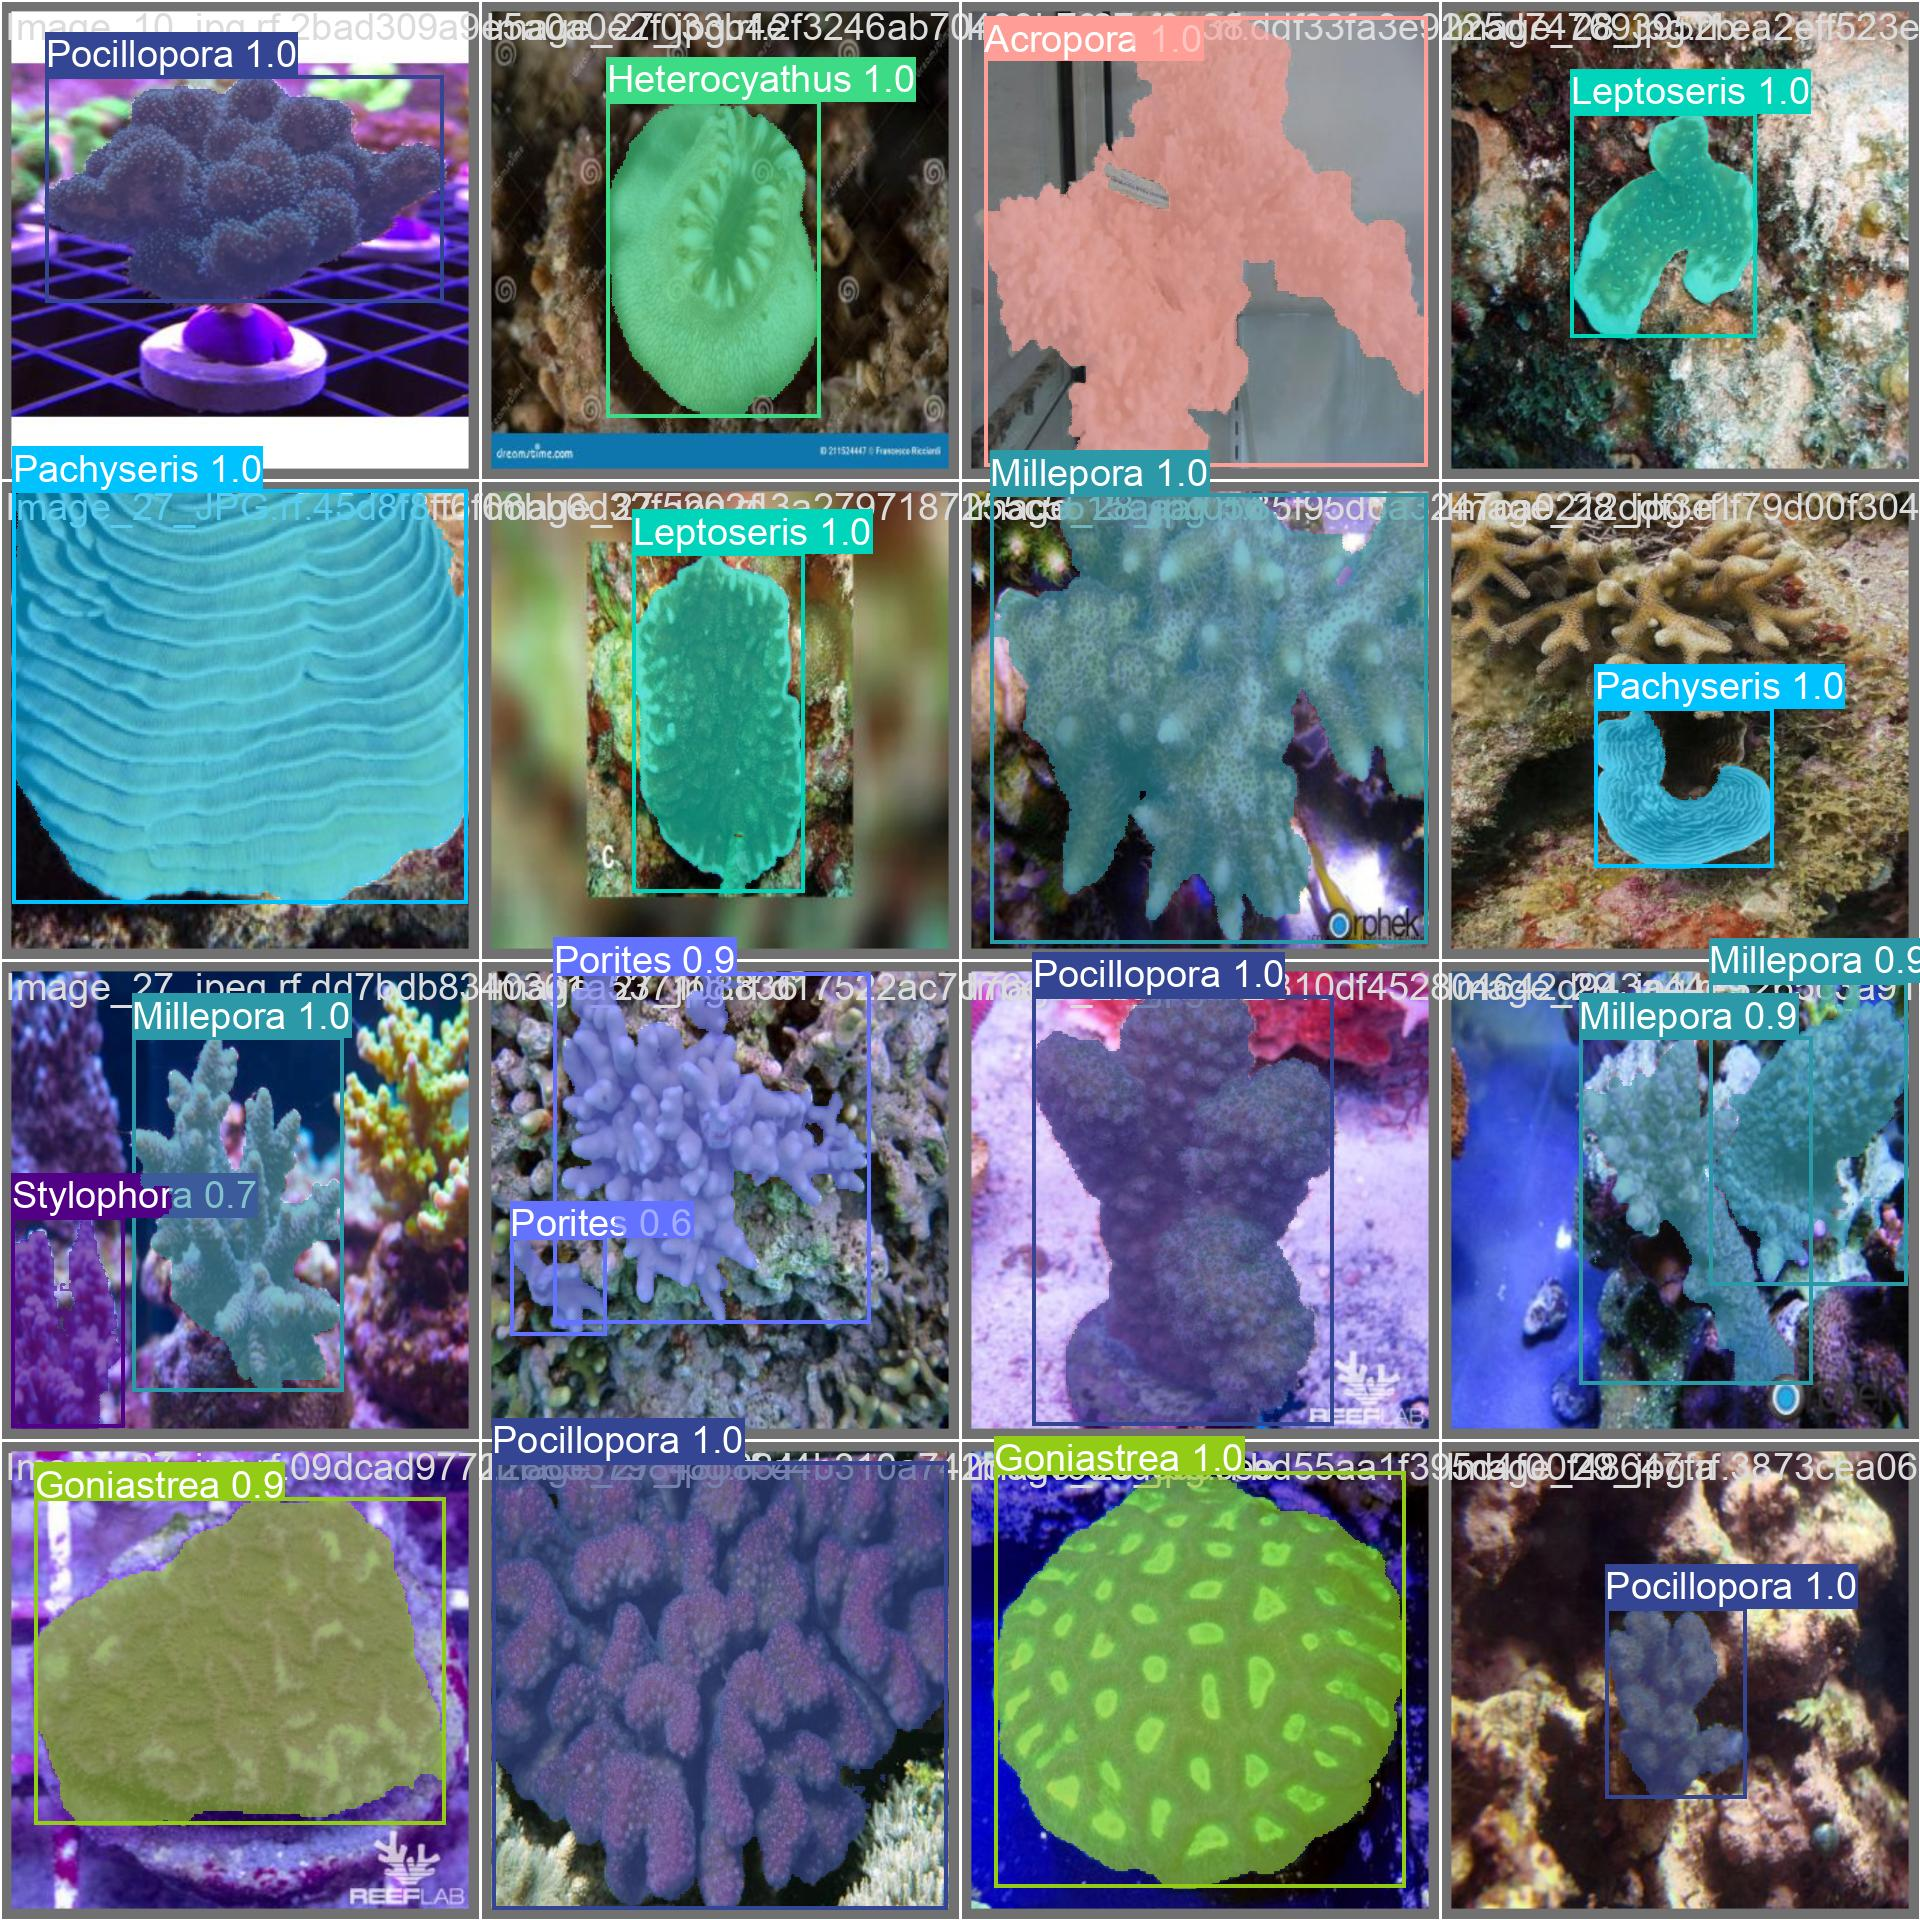

In [14]:
%cd {HOME}
Image(filename=f'{HOME}/runs/segment/train2/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [15]:
%cd {HOME}

!yolo task=segment mode=val model={HOME}/runs/segment/train2/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11786566 parameters, 0 gradients, 42.5 GFLOPs
val: Scanning /content/datasets/Coral_Segmentation-9/valid/labels.cache... 156 images, 0 backgrounds, 0 corrupt: 100% 156/156 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% 10/10 [00:07<00:00,  1.29it/s]
                   all        156        275       0.92      0.759      0.773      0.722      0.901       0.75      0.757      0.678
              Acropora        156          1      0.874          1      0.995      0.995      0.874          1      0.995      0.995
     

## Inference with Custom Model

In [16]:
%cd {HOME}
!yolo task=segment mode=predict model={HOME}/runs/segment/train2/weights/best.pt conf=0.25 source={dataset.location}/test/images save=true

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11786566 parameters, 0 gradients, 42.5 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/153 /content/datasets/Coral_Segmentation-9/test/images/Image_10_jpg.rf.027dd4e7bd5b74b709cc8ad26b872a82.jpg: 640x640 1 Acanthastrea, 21.2ms
image 2/153 /content/datasets/Coral_Segmentation-9/test/images/Image_10_jpg.rf.214140c8a4a24a6a64beade79414f0c2.jpg: 640x640 1 Euphyllia, 21.1ms
image 3/153 /content/datasets/Coral_Segmentation-9/test/images/Image_10_jpg.rf.4e78d18088822a64896902f942317acc.jpg: 640x640 1 Favites, 21.1ms
image 4/153 /content/datasets/Coral_Segmentation-9/test/images/Image_10_jpg.rf.575469d0cad41fc40b03cb87370ee6dd.jpg: 640x640 1 Acropora, 21.1ms
image 5/153 /content/datasets/Coral_Segmentation-9/test/images/Image_10_jpg.rf.b1059e1a98a3413350bbd8e288f62cc7.jpg: 640x640 1 Coeloseris, 21.0ms
image 6/153 /content/datasets/Coral_Segmentatio

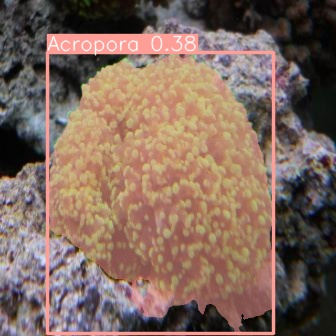

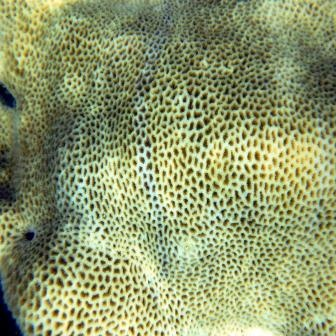

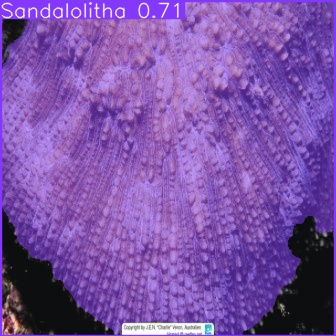

In [18]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/segment/predict/*.jpg')[:3]:
      display(Image(filename=image_path, height=600))
      print("\n")

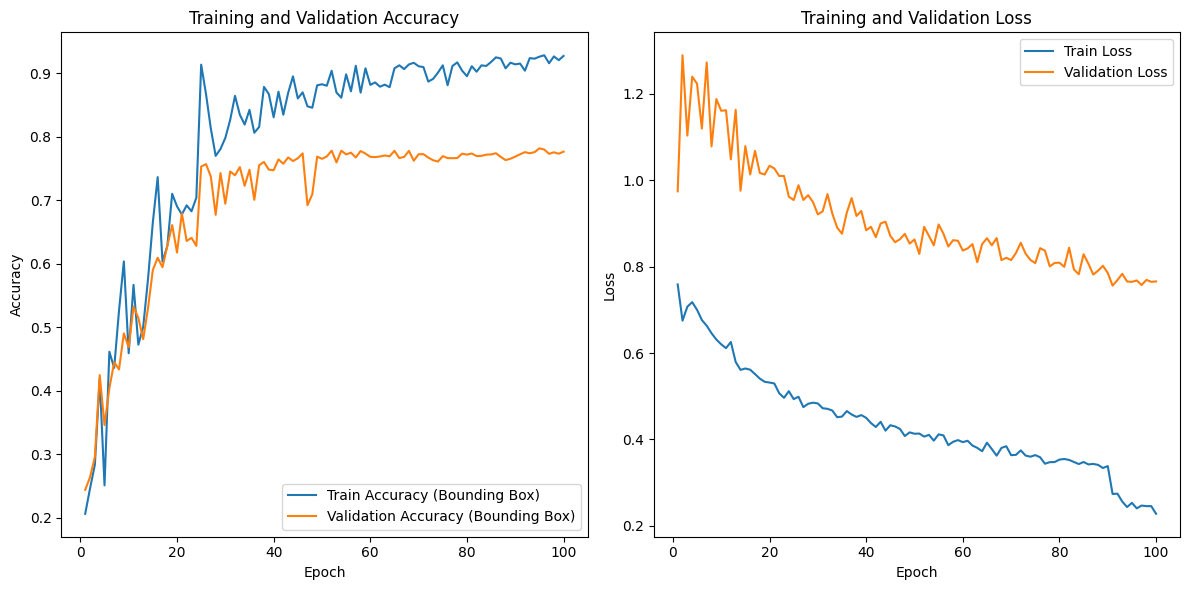

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv("/content/drive/MyDrive/runs/segment/train2/results.csv")

# Remove leading and trailing whitespaces from column names
df.columns = df.columns.str.strip()

# Extract relevant columns
epochs = df["epoch"]
train_acc_bbox = df["metrics/precision(B)"]
val_acc_bbox = df["metrics/mAP50(B)"]
train_loss = df["train/box_loss"]
val_loss = df["val/box_loss"]

# Plotting
plt.figure(figsize=(12, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_bbox, label="Train Accuracy (Bounding Box)")
plt.plot(epochs, val_acc_bbox, label="Validation Accuracy (Bounding Box)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Save & Deploy model

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload and your model weights to Roboflow Deploy for autolabeling, autoscaling inference, and using later.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) supports uploading YOLOv8 weights.

Run this cell to save your model weights:

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project.version(dataset.version).deploy(model_type="yolov8-seg", model_path=f"{HOME}/runs/segment/train/")